### Overview:
This report explores a dataset of trending YouTube videos to uncover patterns and insights related to video performance and viewer engagement. The goal is to understand what factors, such as video length, engagement , or tags contribute to higher view counts. This analysis aims to help content creators and analysts better understand audience behavior and optimize video strategy.

### Data exploratory plan
The data analysis will be divided into four stages:
1) Data Reading/Inspection:
2) Feature Engineering
3) Exploratory Visual Analysis
4) Hypothesis and their testing


### Import libraries

In [82]:
import pandas as pd 
import seaborn as sns
import numpy as np
import isodate
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import kruskal, spearmanr


### **Reading / Inspecting Data**

In [83]:
df = pd.read_csv('youtube_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        600 non-null    object 
 1   title           600 non-null    object 
 2   description     600 non-null    object 
 3   published_date  600 non-null    object 
 4   channel_id      600 non-null    object 
 5   channel_title   600 non-null    object 
 6   tags            600 non-null    object 
 7   category_id     600 non-null    int64  
 8   view_count      600 non-null    float64
 9   like_count      600 non-null    float64
 10  comment_count   600 non-null    float64
 11  duration        600 non-null    object 
 12  thumbnail       600 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 61.1+ KB


##### Summary
The dataset has 600 rows and 13 columns. The target variables we will looking to explore are `view_count`, `like_count`, and `comment_count`, to estimate what factors encourage a video's performance

##### Check null values

In [84]:
df.isnull().sum()

video_id          0
title             0
description       0
published_date    0
channel_id        0
channel_title     0
tags              0
category_id       0
view_count        0
like_count        0
comment_count     0
duration          0
thumbnail         0
dtype: int64

##### Check for Duplicates

In [85]:
df = df.drop_duplicates(keep='first') #removes duplicated rows
df.duplicated().sum()

np.int64(0)

##### Statistics summary and skewness

In [86]:
summary = df.describe()
summary.rename(index={'50%': 'median'}, inplace=True)
summary

,category_id,view_count,like_count,comment_count
count,584.000000,5.840000e+02,5.840000e+02,584.000000
mean,24.916096,8.234730e+06,2.204846e+05,1966.712104
std,4.868227,2.485593e+07,5.135630e+05,4401.828725
min,1.000000,3.120000e+02,0.000000e+00,0.000000
25%,22.000000,9.225175e+04,1.646000e+03,15.000000
median,27.000000,9.909980e+05,2.214900e+04,264.000000
75%,28.000000,6.239264e+06,2.174646e+05,1819.000000
max,30.000000,3.437590e+08,4.421091e+06,40241.000000


In [87]:
columns = ['view_count', 'comment_count', 'like_count']
df[columns].skew()

view_count       7.907754
comment_count    4.565718
like_count       4.429288
dtype: float64

##### Initial Boxplots/Histogram

We plotted boxplots for `view_count`, `like_count`, and `comment_count` to understand the spread of values.
All three variables show a **strong right skew**, with many **extreme outliers**.

Before log transformation

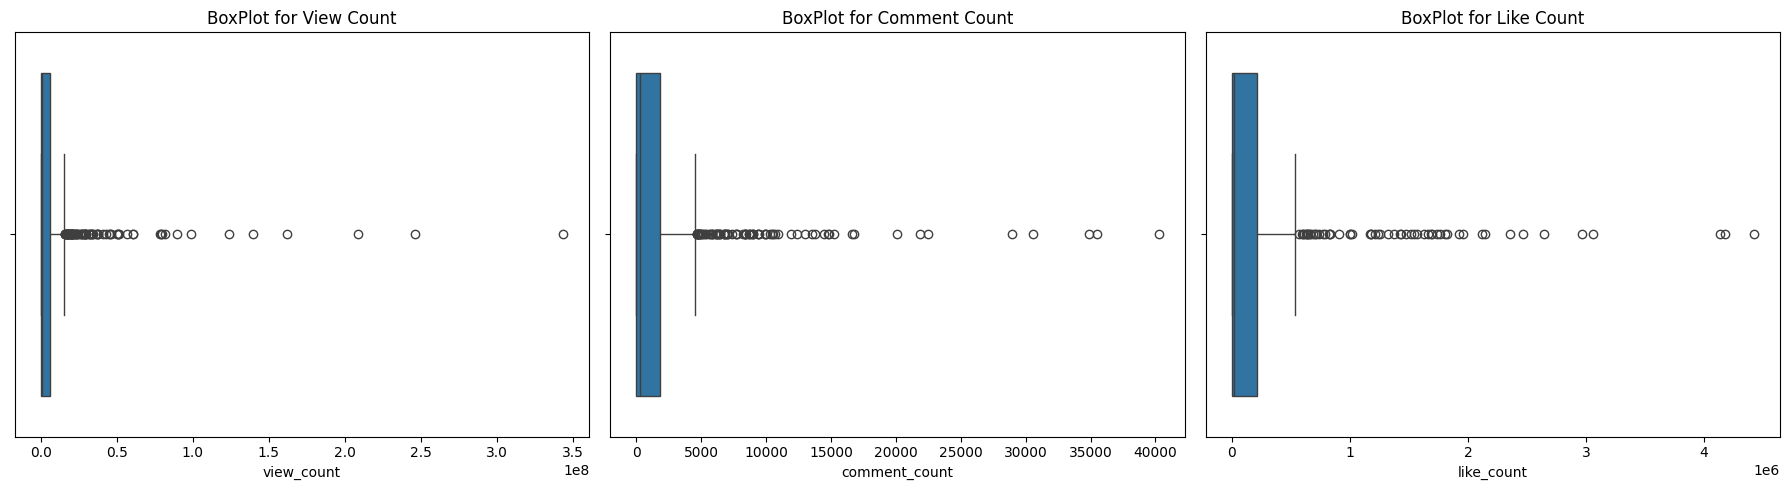

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

sns.boxplot(x=df['view_count'], ax=axes[0])
axes[0].set_title('BoxPlot for View Count')

sns.boxplot(x=df['comment_count'], ax=axes[1])
axes[1].set_title('BoxPlot for Comment Count')

sns.boxplot(x=df['like_count'], ax=axes[2])
axes[2].set_title('BoxPlot for Like Count')

plt.tight_layout()
plt.show()

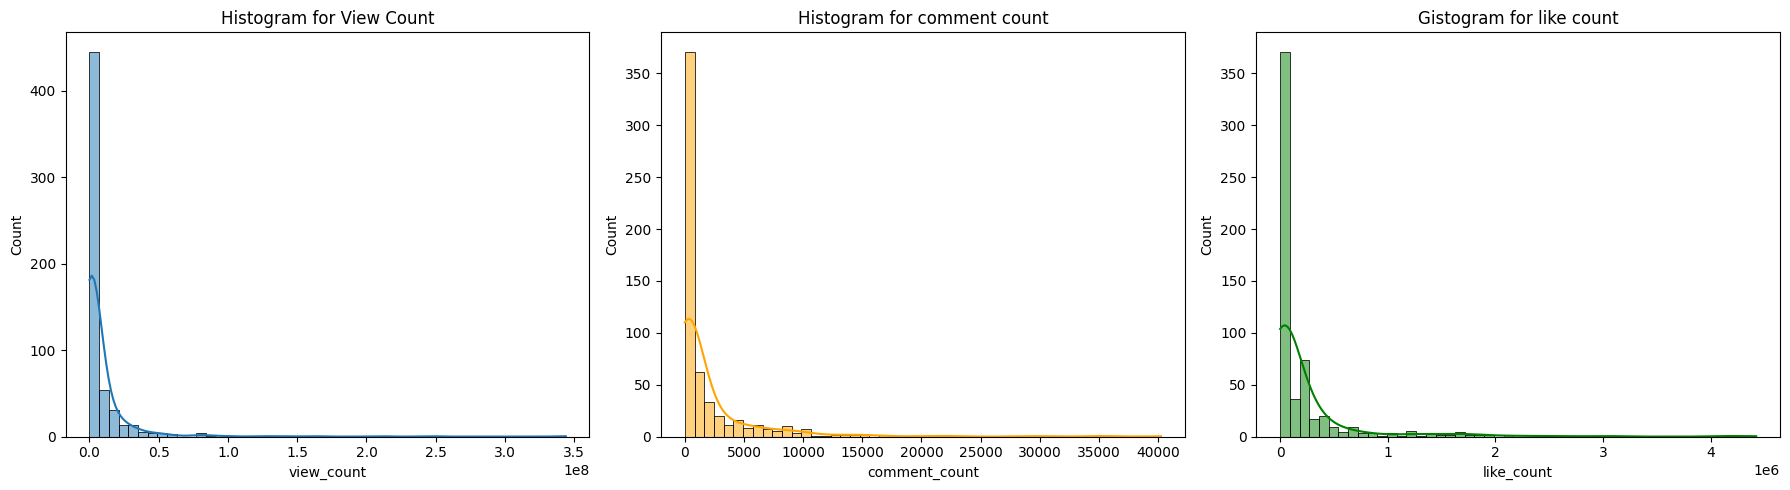

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  


sns.histplot(df['view_count'], kde=True, ax=axes[0])
axes[0].set_title('Histogram for View Count')

sns.histplot(df['comment_count'], kde=True, ax=axes[1], color='orange')
axes[1].set_title('Histogram for comment count')

sns.histplot(df['like_count'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Gistogram for like count')

plt.tight_layout()
plt.show()

##### Log Transformation

To reduce skewness and make the distributions more interpretable, we applied log transformation to the key engagement metrics.

- After transformation, the boxplots show a **more symmetric distribution**.
- This helps us visualize patterns more clearly  and is also useful for statistical testing

After log transformation

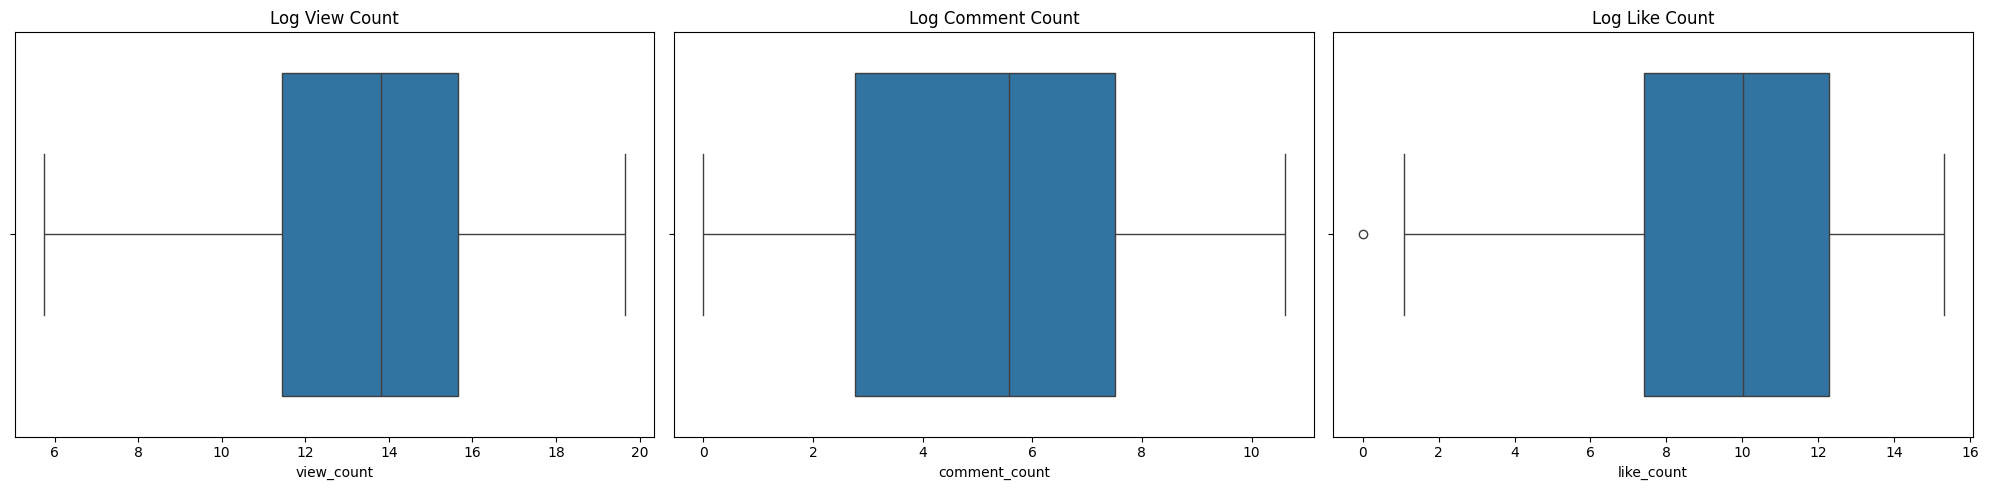

In [90]:
df[columns] = df[columns].apply(np.log1p)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns

sns.boxplot(x=df['view_count'], ax=axes[0])
axes[0].set_title('Log View Count')

sns.boxplot(x=df['comment_count'], ax=axes[1])
axes[1].set_title('Log Comment Count')

sns.boxplot(x=df['like_count'], ax=axes[2])
axes[2].set_title('Log Like Count')

plt.tight_layout()
plt.show()

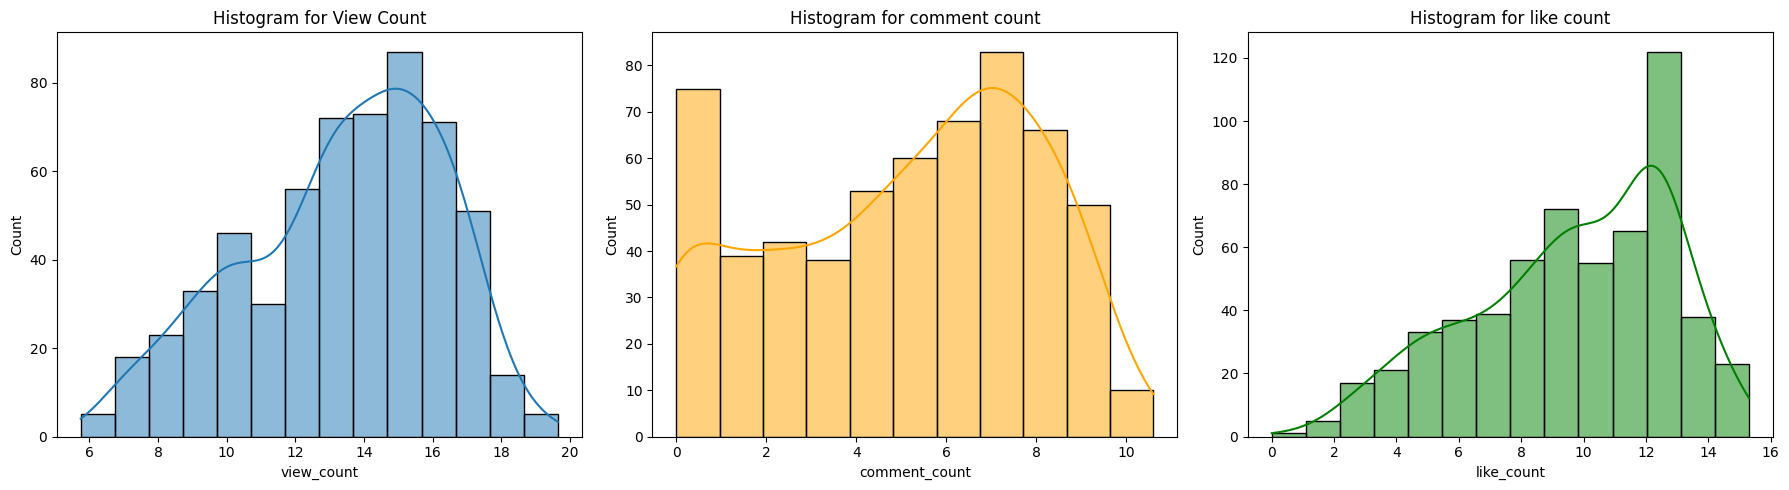

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  


sns.histplot(df['view_count'], kde=True, ax=axes[0])
axes[0].set_title('Histogram for View Count')

sns.histplot(df['comment_count'], kde=True, ax=axes[1], color='orange')
axes[1].set_title('Histogram for comment count')

sns.histplot(df['like_count'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Histogram for like count')

plt.tight_layout()
plt.show()

### **Feature Engineering**

##### Convert  ISO 8601 duration string into seconds

In [92]:
df['duration']=df['duration'].apply( lambda x : isodate.parse_duration(x).total_seconds())
df.rename(columns={'duration': 'Duration in sec'}, inplace=True)
df['Duration in sec']

0       57.0
1      470.0
2       47.0
3       31.0
4       16.0
       ...  
595     60.0
596     48.0
597     10.0
598      6.0
599      6.0
Name: Duration in sec, Length: 584, dtype: float64

##### Categorizing Duration (Short, Medium, Long)

In [93]:
def categorize_duration(seconds):
    if seconds < 60:
        return 'Short'
    elif seconds <= 300:
        return 'Medium'
    else:
        return 'Long'

df['duration_category'] = df['Duration in sec'].apply(categorize_duration)


##### Convert IS0 8601 date into readable format

In [94]:
df['published_date'] = pd.to_datetime(df['published_date'])
df['published_date']

0     2025-05-02 17:37:10+00:00
1     2025-06-18 12:39:53+00:00
2     2022-11-01 11:00:06+00:00
3     2024-07-08 18:04:31+00:00
4     2024-12-22 16:49:00+00:00
                 ...           
595   2022-05-03 22:23:10+00:00
596   2025-06-20 05:15:19+00:00
597   2025-06-19 13:39:44+00:00
598   2025-06-20 02:00:02+00:00
599   2025-06-19 15:16:47+00:00
Name: published_date, Length: 584, dtype: datetime64[ns, UTC]

##### Create `days_since_publish` column to calculate how many days have passed since a video got published

In [95]:
reference_date = df['published_date'].max()
df['days_since_publish'] = (reference_date - df['published_date']).dt.days

##### `engagement_velocity` column, which indicates how good the videos are at getting engagement per day since they were published.

In [96]:
dates = df['days_since_publish'].replace(0, np.nan) #to avoid errors when later creating enegagement velocity
df['engagement_velocity'] = (df['like_count'] + df['comment_count']) / dates

##### `engagement` column, which reveals how engaging the video is, in terms of views and comments

In [97]:
df['engagement'] = ((df['like_count'] + df['comment_count']) / df['view_count'])

##### Add `tag_count column`, which counts the number of tags used in a video

In [98]:
#First convert string list into actual lists
import ast
df['tags'] = df['tags'].apply(ast.literal_eval)
#tag_count
df['tag_count'] = df['tags'].apply(len)

### **Exploratory Visual Analysis**

##### Identifying Factors affecting view count
After examining the distribution of view counts and handling outliers using log transformation, the next step is to explore factors effecting view count

In [99]:
top = df.sort_values('view_count', ascending=False).head(50)

In [100]:
fig = px.scatter(
    top,
    x='view_count',
    y='engagement',
    size='Duration in sec',
    size_max=50,
    color='tag_count',
    width=1000,
    height=1000,
    hover_name='title',
    title = 'What drives views in a video?',
    labels={'view_count' : 'Total view', 'engagement' : 'Engagement'},
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(showlegend=True )  
fig.show()


- High-view videos show similar engagement (1.0–1.4) as mid-range viewed videos.
- Long and short videos both succeed. No duration guarantees virality.
- A 19M-view video with low engagement (1.1) may rely on external traffic, while a high-engagement (1.3) video with fewer views suggests a niche audience.

##### How Quickly Do Top Videos Gain Views?
We will plot a graph of engagement velocity and published date for top 100 most viewed videos

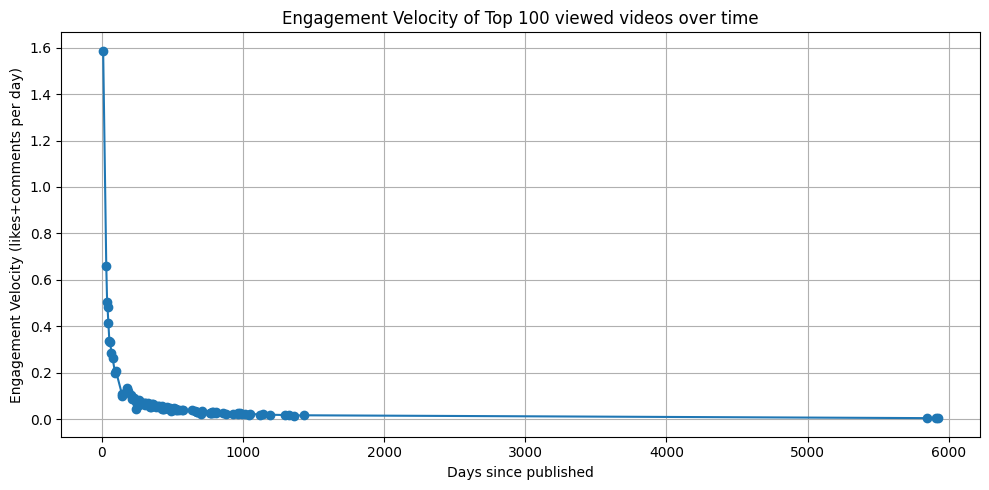

In [101]:
top100_sorted = df.sort_values(by='view_count', ascending=False).head(100).sort_values(by='days_since_publish')

plt.figure(figsize=(10,5))
plt.plot(top100_sorted['days_since_publish'], top100_sorted['engagement_velocity'], marker='o', linestyle='-')
plt.title('Engagement Velocity of Top 100 viewed videos over time')
plt.xlabel('Days since published')
plt.ylabel('Engagement Velocity (likes+comments per day)')
plt.grid()
plt.tight_layout()
plt.show()

- Very recent videos tend to have very high engagement velocity, people are interacting rapidly.
- As videos age, the engagement velocity drops significantly, stabilizing to near-zero levels.
- This suggests that engagement velocity is strongest in the first few days after a video is published.

##### Engagement vs View count line plot. 

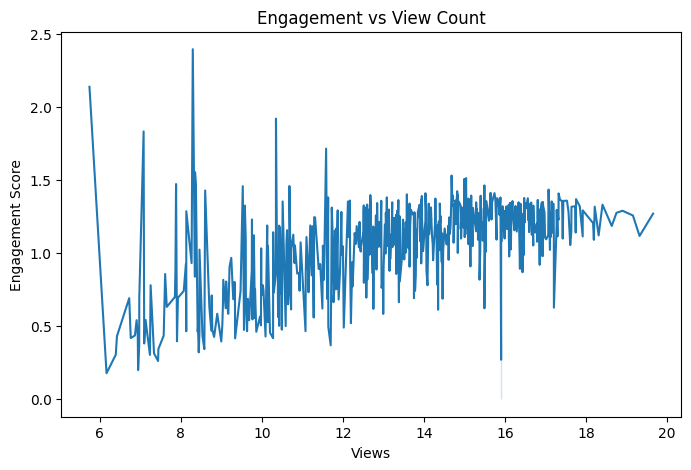

In [102]:
plt.figure(figsize=(8,5))
sns.lineplot(x='view_count', y='engagement', data=df)
plt.title('Engagement vs View Count')
plt.xlabel('Views')
plt.ylabel('Engagement Score')
plt.show()


The plot shows that:
- Videos with fewer views tend to have higher but volatile engagement scores. This is likely due to small audiences being more engaged, but also due to statistical instability when dividing by a small view count.
- As view count increases, the engagement score stabilizes, clustering around ~1.0. This suggests that large viewed videos have more consistent but relatively lower per-view engagement, possibly due to wider audience reach but lower personal interest.

##### How much is the count of each duration category?

<Axes: xlabel='duration_category', ylabel='count'>

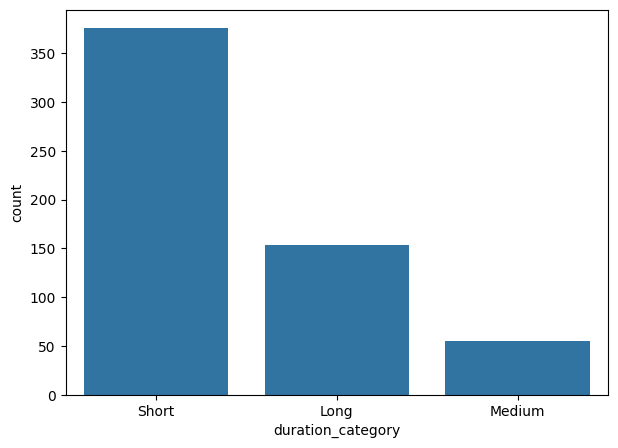

In [103]:
plt.figure(figsize=(7,5))
sns.countplot(x='duration_category', data=df)

Most of the videos in sample data fall under the category of 'short' video (<60)

##### Heatmap for key video metrics

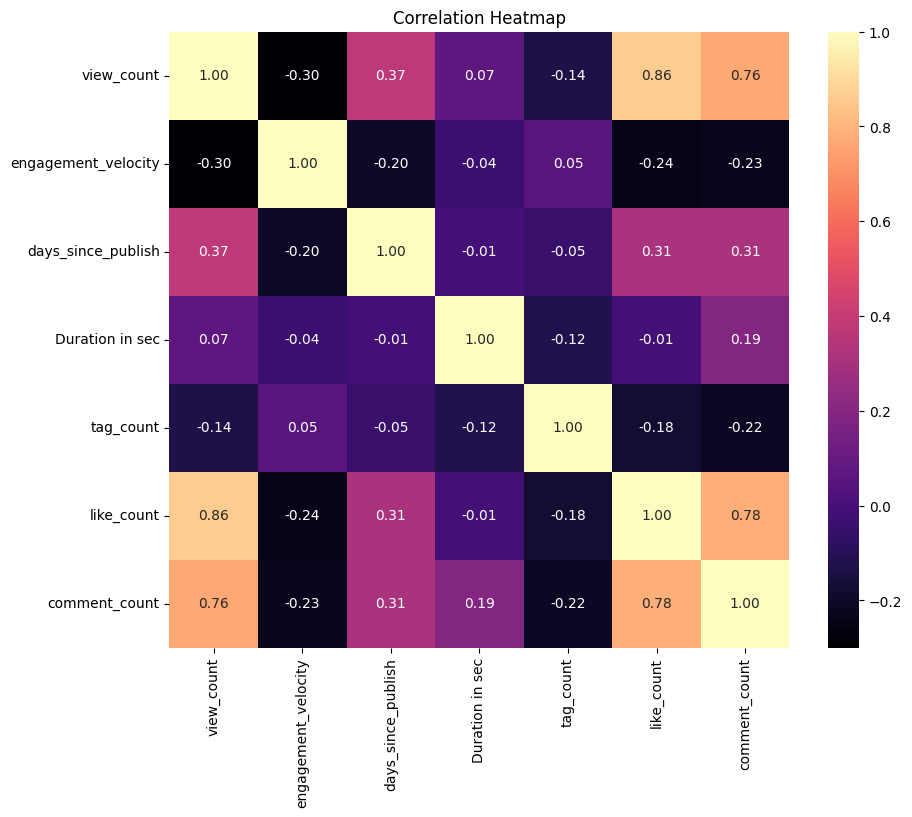

In [104]:
cols = ['view_count', 'engagement_velocity', 'days_since_publish',
        'Duration in sec', 'tag_count', 'like_count', 'comment_count']

# Compute correlation matrix
corr = df[cols].corr()
plt.figure(figsize=(10, 8))  # size of the plot
sns.heatmap(corr, annot=True, cmap='magma', fmt=".2f", linewidths=0)
plt.title("Correlation Heatmap")
plt.show()

**Important Takeaways**
- Likes and views are highly correlated (r=0.86), same goes for comments and views (r=0.78), suggesting engaged viewers do both.
- Likes and enagement velocity show negative correlation, means a trending video does not gurantee many likes.
- Views and duration have near zero correlation(0.07), debunking 'longer videos = more views' as a universal rule.
- Tag count and view counts have a negative correlation.

### **Hypothesis Testing**

##### Hypothesis 1 : Does duration category(short, medium, long) effect view_count?

 H0: Duration category has no effect on view count <br>
 H1: Duration category has effect on view count

In [105]:
short = df[df['duration_category'] == 'Short']['view_count']
medium = df[df['duration_category'] == 'Medium']['view_count']
long = df[df['duration_category'] == 'Long']['view_count']
stat, p_value = kruskal(short, medium, long)
print(f"Kruskal-Wallis p-value: {p_value:.4f}")

Kruskal-Wallis p-value: 0.0767


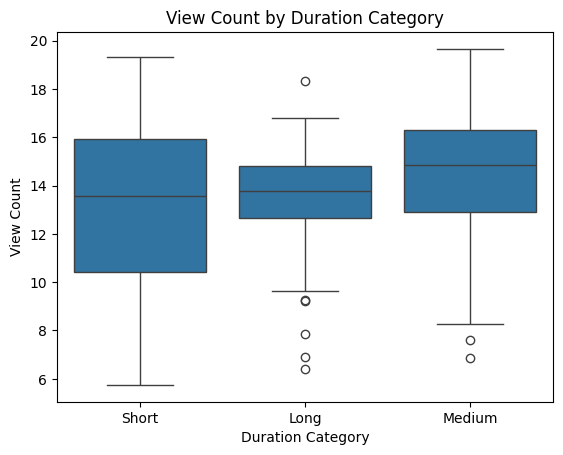

In [106]:
sns.boxplot(x='duration_category', y='view_count', data=df)
plt.title("View Count by Duration Category")
plt.xlabel('Duration Category')
plt.ylabel('View Count')
plt.show()

 Conclusion: Based on the Kruskal-Wallis test, we fail to reject the null hypothesis. This suggests that there is no statistically significant difference in view counts across different video duration categories.

##### Hypothesis 2 : Do number of tags efffect view count?

H0 : There is no significant correlation between the number of tags and view count.<br>
H1 : There is a significant correlation between the number of tags and view count.

In [107]:
                                # Statistical Test (Spearman)
corr, pval = spearmanr(df['tag_count'], df['view_count'])
print(f"Correlation: {corr}, P Value: {pval}")

Correlation: -0.11368145819753249, P Value: 0.005954593666120997


Text(0.5, 1.0, 'Tag count vs view count')

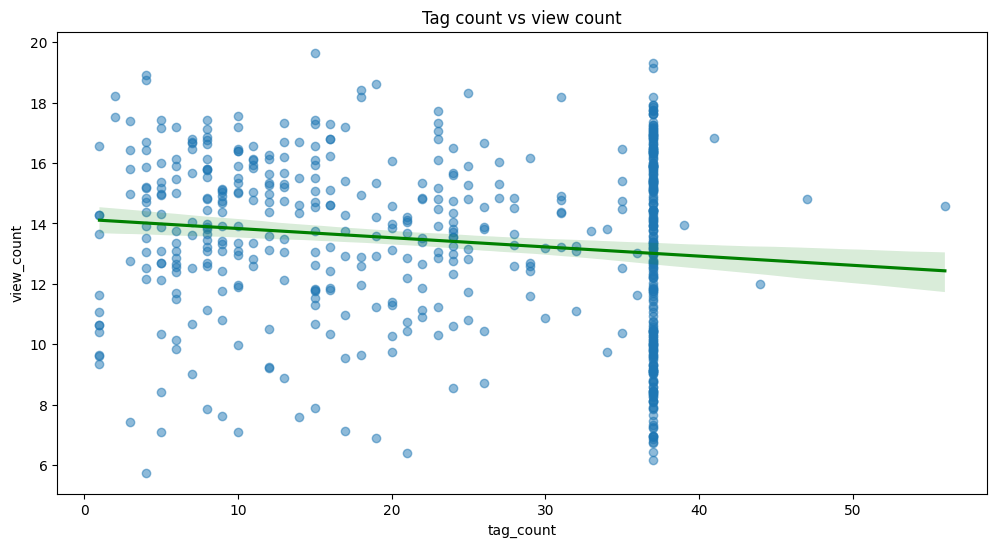

In [108]:
plt.figure(figsize=(12,6))
sns.regplot(x='tag_count', y='view_count', data=df,  scatter_kws={'alpha': 0.5}, line_kws={'color' :'green'})
plt.title("Tag count vs view count")

Conclusion: Null hypothesis is rejected, since p value < 0.05. This indicates a statistically significant correlation between tag count and view count however the correlation is weak and negative as (Spearman’s ρ = -0.113,)

### **Key Insights and Findings**

##### *Data Overview & Quality*

- The dataset contains 600 rows and 13 columns, with no missing values or duplicates initially detected.
- Numerical features (e.g., view_count, like_count, comment_count) exhibited heavy right-skewness, requiring log transformation for better analysis.

##### *Feature Engineering & Transformations*
- Duration Conversion: ISO 8601 duration strings were converted into seconds and categorized into Short (<60s), Medium (60s–300s), and Long (>300s) for comparative analysis.
- Date Handling: Published dates in ISO 8601 format were parsed into datetime objects, enabling the creation of a days_since_publish column.

Engagement Metrics: <br>
Engagement : Defined as (like_count + comment_count) / view_count to measure audience interaction.
Engagement Velocity: Computed as (like_count + comment_count) / days_since_publish to assess how quickly engagement accumulates post-publishing.

##### *Exploratory Data Analysis (EDA) Insights*

- Strong positive correlations:
    * Likes vs. Views (r=0.86)
    * Comments vs. Views (r=0.78)
    This suggests that higher engagement (likes/comments) correlates with higher viewership.

- Kruskal-Wallis test indicated no statistically significant difference in view counts across duration categories (Short, Medium, Long).
However, short videos (<60s) dominated the dataset, possibly due to platform trends favoring concise content.
Tag Count Influence:

- Spearman test showed weak correlation between tag count and view count, indicating tags may not significantly impact reach.

- Engagement Velocity Trends:
Highest engagement occurs within the first few days after publishing, followed by a decline—consistent with typical content decay patterns.

- Multivariate Analysis
Bubble Plot (Top 50 Videos):
High-view videos did not always have the highest engagement, suggesting algorithmic promotion  may play a larger role in virality than raw engagement metrics.

##### *Limitations*
- The analysis is based on only 600 videos, while YouTube hosts billions of videos across diverse categories.
- Findings may not generalize to the entire platform due to potential sampling bias.


### **Conclusion**

This analysis reveals that engagement (likes/comments) strongly correlates with viewership, but video duration and tag count have negligible effects. Short-form content dominates the dataset.

Key Takeaways for Content Creators:
- Prioritize engagement: Encouraging likes and comments may boost visibility.
- Optimize early momentum: Maximize engagement in the first few days post-publishing.
- Duration flexiblity: Since length doesn’t significantly impact views, focus on content quality over strict duration constraints.

##### Next Steps:
- Expand Dataset – Gather more videos to see bigger trends
- Creator-Specific Factors – Investigate channel size, subscriber base, and posting frequency.
- Predictive Modeling – Build a regression/ML model to predict virality.